In [1]:
import sys; print(sys.executable)

C:\Users\DELL\anaconda3\envs\pointpillars\python.exe


In [1]:
#CELL A
import sys, os
print("Python exe:", sys.executable)

# Point to your KITTI data (the training split you downloaded)
KITTI_DIR = r"C:\Users\DELL\OpenPCDet\data\kitti\training"  # <-- change if you put it elsewhere
assert os.path.isdir(os.path.join(KITTI_DIR, "velodyne")), "velodyne/ not found — fix KITTI_DIR"

# Where to save outputs (keep it clean & outside OpenPCDet)
PROJECT_DIR = r"C:\Users\DELL\projects\bev_npu"
os.makedirs(os.path.join(PROJECT_DIR, "outputs", "bev_float"), exist_ok=True)
os.makedirs(os.path.join(PROJECT_DIR, "outputs", "bev_u8"),    exist_ok=True)
os.makedirs(os.path.join(PROJECT_DIR, "outputs", "tiles"),      exist_ok=True)
print("Project dir:", PROJECT_DIR)


Python exe: C:\Users\DELL\anaconda3\envs\pointpillars\python.exe
Project dir: C:\Users\DELL\projects\bev_npu


In [2]:
from pathlib import Path

# Point to the *training root* that directly contains velodyne/, calib/, label_2/, image_2/
KITTI_DIR = Path(r"C:\Users\DELL\OpenPCDet\data\kitti\training")
VELO      = KITTI_DIR / "velodyne"
CALIB_DIR = KITTI_DIR / "calib"      # (for later)
LABEL_DIR = KITTI_DIR / "label_2"    # (for later)
IMG_DIR   = KITTI_DIR / "image_2"    # (optional)

# Sanity checks
assert KITTI_DIR.is_dir(), "KITTI_DIR doesn't exist"
assert VELO.is_dir() and any(VELO.glob("*.bin")), "No .bin files found in KITTI_DIR/velodyne"
print("Using KITTI_DIR:", KITTI_DIR)
print("LiDAR frames:", len(list(VELO.glob('*.bin'))))

# If you’re not sure which frame IDs exist, list a few:
avail = sorted(p.stem for p in VELO.glob("*.bin"))
print("First few frames:", avail[:5])


Using KITTI_DIR: C:\Users\DELL\OpenPCDet\data\kitti\training
LiDAR frames: 7486
First few frames: ['000000', '000001', '000002', '000003', '000004']


In [3]:
%pip install -q numpy matplotlib opencv-python tqdm

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import numpy as np, cv2, matplotlib
print("ok:", np.__version__, cv2.__version__, matplotlib.__version__)

ok: 1.24.1 4.12.0 3.7.5


In [32]:
#CELL C
from pathlib import Path
import json

cfg = {
    # KITTI LiDAR coords: x=forward, y=left(+)/right(-), z=up
    "x_range": [0.0, 70.4],     # forward span (meters)  → maps to rows (H)
    "y_range": [-40.0, 40.0],   # lateral span (meters)  → maps to cols (W)
    "z_range": [-3.0, 1.0],     # vertical crop (meters)

    # ~0.1 m ground resolution commonly used in literature
    "H": 704,   # rows along +x (forward)
    "W": 800,   # cols along +y (left/right)

    "channels": ["count","z_max","z_mean","i_mean","z_var"],

    # Initial quant caps (we’ll histogram once, then freeze)
    "q": {"count_cap": 5.0, "zvar_cap": 0.2}
}

cfg_dir = Path(PROJECT_DIR) / "configs"
cfg_dir.mkdir(parents=True, exist_ok=True)
(cfg_dir / "bev_config.json").write_text(json.dumps(cfg, indent=2))
cfg

{'x_range': [0.0, 70.4],
 'y_range': [-40.0, 40.0],
 'z_range': [-3.0, 1.0],
 'H': 704,
 'W': 800,
 'channels': ['count', 'z_max', 'z_mean', 'i_mean', 'z_var'],
 'q': {'count_cap': 5.0, 'zvar_cap': 0.2}}

In [33]:
#CELL D
import numpy as np

def bev_from_points(points: np.ndarray, cfg: dict) -> np.ndarray:
    """
    points: [N,4] float32 -> (x,y,z,intensity) in KITTI coords (x fwd, y left, z up)
    return: [5,H,W] float -> [count, z_max, z_mean, i_mean, z_var]
    """
    x, y, z, i = points.T
    xr, yr, zr = cfg["x_range"], cfg["y_range"], cfg["z_range"]
    H, W = cfg["H"], cfg["W"]

    # 1) ROI filter
    m = (x>=xr[0])&(x<=xr[1])&(y>=yr[0])&(y<=yr[1])&(z>=zr[0])&(z<=zr[1])
    x, y, z, i = x[m], y[m], z[m], i[m]

    # 2) Map meters → integer grid indices
    # rows (iy) track forward x, cols (ix) track lateral y
    row_scale = (H - 1) / (xr[1] - xr[0])   # rows per meter (forward)
    col_scale = (W - 1) / (yr[1] - yr[0])   # cols  per meter (lateral)
    iy = np.floor((x - xr[0]) * row_scale).astype(np.int32)  # 0..H-1
    ix = np.floor((y - yr[0]) * col_scale).astype(np.int32)  # 0..W-1
    lin = iy * W + ix

    # 3) Per-cell reductions
    count = np.bincount(lin, minlength=H*W).astype(np.float32).reshape(H, W)
    sum_z  = np.bincount(lin, weights=z,   minlength=H*W).reshape(H, W)
    sum_z2 = np.bincount(lin, weights=z*z, minlength=H*W).reshape(H, W)
    sum_i  = np.bincount(lin, weights=i,   minlength=H*W).reshape(H, W)

    # 4) z_max via scatter-max
    zmax = np.full(H*W, -1e9, dtype=np.float32)
    np.maximum.at(zmax, lin, z)
    zmax = zmax.reshape(H, W)

    # 5) Derived stats
    eps   = 1e-6
    zmean = sum_z / np.maximum(count, eps)
    imean = sum_i / np.maximum(count, eps)
    zvar  = (sum_z2 / np.maximum(count, eps)) - zmean**2
    zvar  = np.clip(zvar, 0.0, None)

    return np.stack([count, zmax, zmean, imean, zvar], axis=0)

def quantize_bev_u8(bev: np.ndarray, cfg: dict) -> np.ndarray:
    """
    Map float channels into [0..255] uint8 using fixed caps/scales.
    """
    zr = cfg["z_range"]
    count_cap, zvar_cap = cfg["q"]["count_cap"], cfg["q"]["zvar_cap"]

    # count: 0..count_cap → 0..255 (clip)
    q0 = np.clip((bev[0] / count_cap) * 255.0, 0, 255).astype(np.uint8)

    # heights: z in [zr[0], zr[1]] → 0..255
    z_to_u8 = lambda arr: np.clip(((arr - zr[0]) / (zr[1] - zr[0])) * 255.0, 0, 255).astype(np.uint8)
    q1 = z_to_u8(bev[1])   # z_max
    q2 = z_to_u8(bev[2])   # z_mean

    # intensity mean: assume 0..1 → 0..255
    q3 = np.clip(bev[3] * 255.0, 0, 255).astype(np.uint8)

    # variance: 0..zvar_cap → 0..255
    q4 = np.clip((bev[4] / zvar_cap) * 255.0, 0, 255).astype(np.uint8)

    return np.stack([q0, q1, q2, q3, q4], axis=0)

In [34]:
frame_id = avail[50]

Frame 000050 | points: 108348
Ranges: x[-79.5,79.4]  y[-14.6,23.3]  z[-13.4,2.9]


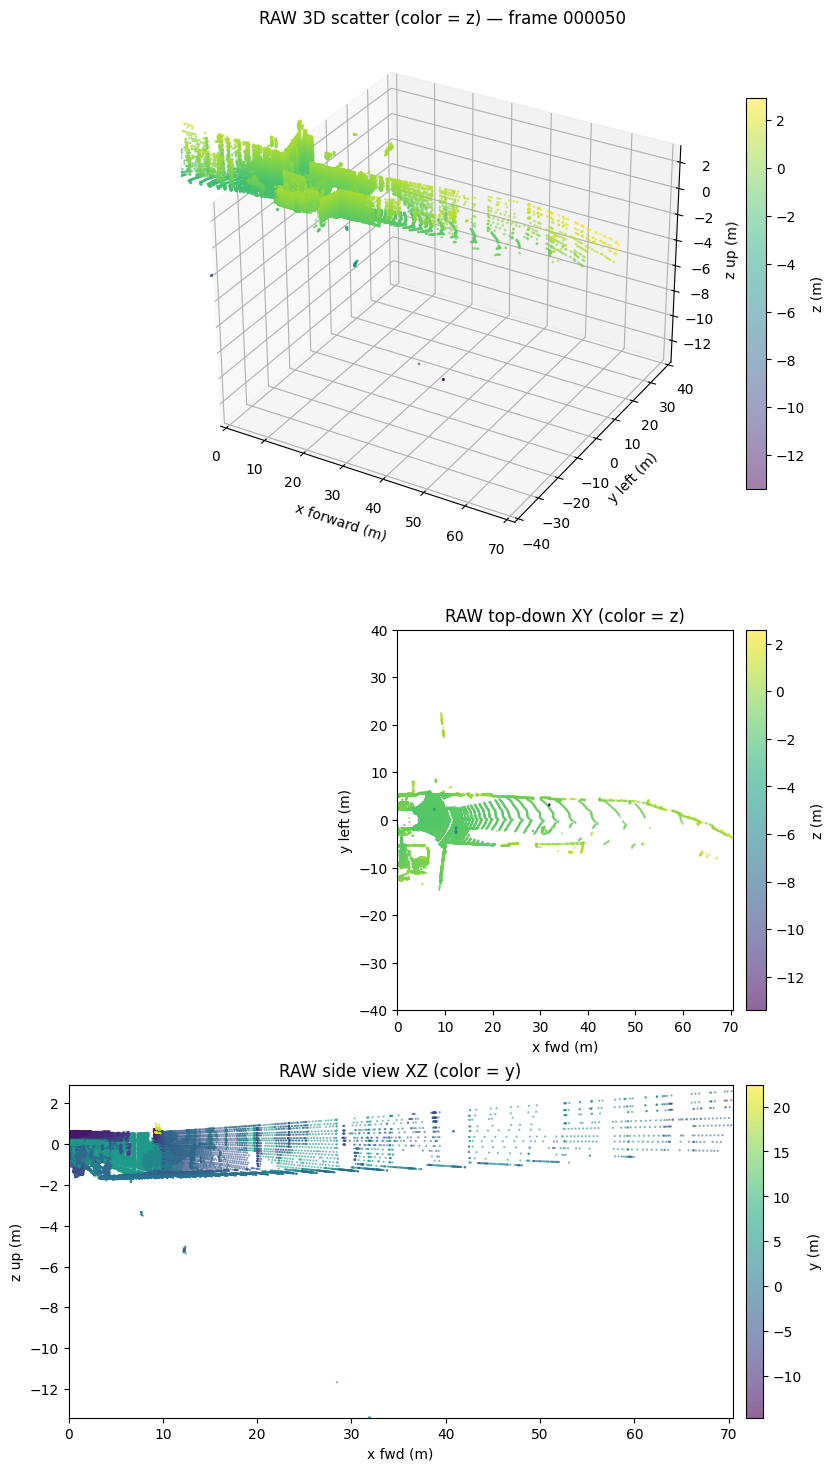

In [35]:
# Cell E0 — RAW LiDAR visualization (stacked, bigger) for ONE frame
import numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # keep for 3D projection

# === pick a frame ===
try:
    fid = frame_id
except NameError:
    avail = sorted(p.stem for p in VELO.glob("*.bin"))
    print("Frames available:", len(avail), "| first few:", avail[:5])
    fid = avail[0]               # <-- change to e.g. "000123" or avail[k]

raw = np.fromfile(VELO / f"{fid}.bin", dtype=np.float32).reshape(-1, 4)
x, y, z, inten = raw.T
xr, yr, zr = cfg["x_range"], cfg["y_range"], cfg["z_range"]

print(f"Frame {fid} | points: {len(raw)}")
print(f"Ranges: x[{x.min():.1f},{x.max():.1f}]  y[{y.min():.1f},{y.max():.1f}]  z[{z.min():.1f},{z.max():.1f}]")

# (light) downsample for faster plotting — tweak if needed
Nplot = min(len(raw), 80000)   # smaller = faster; larger = denser plot
idx = np.random.choice(len(raw), size=Nplot, replace=False) if len(raw) > Nplot else np.arange(len(raw))
xs, ys, zs = x[idx], y[idx], z[idx]

# ROI mask for 2D views
m = (x>=xr[0])&(x<=xr[1])&(y>=yr[0])&(y<=yr[1])

# --- stacked layout ---
fig = plt.figure(figsize=(9, 18))
gs = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[2.2, 1.6, 1.4], hspace=0.18)

# 1) 3D scatter (color by z)
ax3d = fig.add_subplot(gs[0], projection='3d')
s3d = 1.0  # marker size (tweak)
sc3d = ax3d.scatter(xs, ys, zs, c=zs, s=s3d, alpha=0.5, cmap='viridis')
ax3d.set_title(f"RAW 3D scatter (color = z) — frame {fid}")
ax3d.set_xlabel("x forward (m)"); ax3d.set_ylabel("y left (m)"); ax3d.set_zlabel("z up (m)")
ax3d.set_xlim(xr); ax3d.set_ylim(yr); ax3d.set_zlim(z.min(), z.max())
cb3d = fig.colorbar(sc3d, ax=ax3d, fraction=0.028, pad=0.06); cb3d.set_label("z (m)")

# 2) Top-down XY scatter (color by z)
axXY = fig.add_subplot(gs[1])
s2d = 0.3  # marker size for 2D plots (tweak)
scXY = axXY.scatter(x[m], y[m], c=z[m], s=s2d, alpha=0.6, cmap='viridis')
axXY.set_aspect('equal', 'box'); axXY.set_xlim(xr); axXY.set_ylim(yr)
axXY.set_title("RAW top-down XY (color = z)")
axXY.set_xlabel("x fwd (m)"); axXY.set_ylabel("y left (m)")
cbXY = fig.colorbar(scXY, ax=axXY, fraction=0.028, pad=0.02); cbXY.set_label("z (m)")

# 3) Side view XZ (color by y)
axXZ = fig.add_subplot(gs[2])
scXZ = axXZ.scatter(x[m], z[m], c=y[m], s=s2d, alpha=0.6, cmap='viridis')
axXZ.set_xlim(xr); axXZ.set_ylim(z.min(), z.max())  # or use zr for fixed limits
axXZ.set_title("RAW side view XZ (color = y)")
axXZ.set_xlabel("x fwd (m)"); axXZ.set_ylabel("z up (m)")
cbXZ = fig.colorbar(scXZ, ax=axXZ, fraction=0.028, pad=0.02); cbXZ.set_label("y (m)")

plt.show()

# make sure the next cell (E) reuses this frame
frame_id = fid


Total frames: 7486 | first few: ['000000', '000001', '000002', '000003', '000004']
bev_f (5, 704, 800) float64 | bev_u (5, 704, 800) uint8


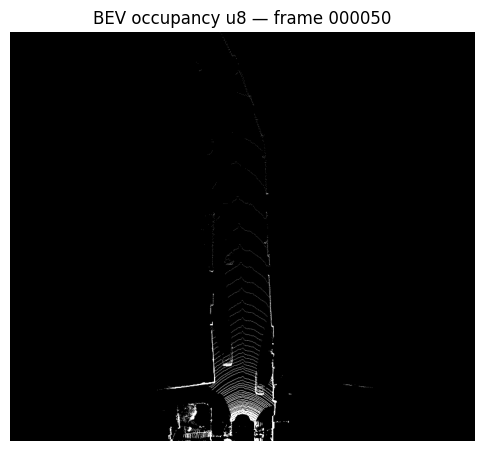

Saved: C:\Users\DELL\projects\bev_npu\outputs\bev_float\000050.npy and C:\Users\DELL\projects\bev_npu\outputs\bev_u8\000050.npy


In [36]:
# Cell E — run ONE frame → visualize → save
from pathlib import Path
import numpy as np, matplotlib.pyplot as plt

# pick an existing frame id (don’t hardcode 000000 if it’s missing)
avail = sorted(p.stem for p in (VELO.glob("*.bin")))
print("Total frames:", len(avail), "| first few:", avail[:5])
  

raw = np.fromfile(VELO / f"{frame_id}.bin", dtype=np.float32).reshape(-1, 4)

bev_f = bev_from_points(raw, cfg)    # float [5,H,W]
bev_u = quantize_bev_u8(bev_f, cfg)  # u8   [5,H,W]

print("bev_f", bev_f.shape, bev_f.dtype, "| bev_u", bev_u.shape, bev_u.dtype)

plt.figure(figsize=(6,6))
plt.imshow(bev_u[0], cmap='gray', origin='lower')   # occupancy
plt.title(f"BEV occupancy u8 — frame {frame_id}")
plt.axis('off'); plt.show()

outF = Path(PROJECT_DIR) / "outputs" / "bev_float"; outF.mkdir(parents=True, exist_ok=True)
outU = Path(PROJECT_DIR) / "outputs" / "bev_u8";    outU.mkdir(parents=True, exist_ok=True)
np.save(outF / f"{frame_id}.npy", bev_f)
np.save(outU / f"{frame_id}.npy", bev_u)
print("Saved:", outF/f"{frame_id}.npy", "and", outU/f"{frame_id}.npy")


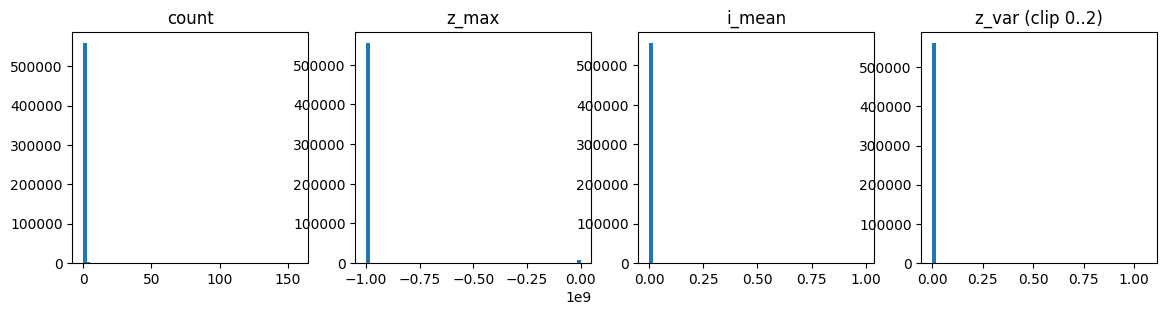

count cap=5.0 → %clipped: 0.44%
zvar  cap=0.2  → %clipped: 0.08%


In [37]:
# Cell F — histograms + clip stats (tune caps once, then freeze)
import numpy as np, matplotlib.pyplot as plt

def clip_ratio_u8(arr_u8: np.ndarray) -> float:
    return float((arr_u8 == 255).sum()) / arr_u8.size

fig,axs = plt.subplots(1,4,figsize=(14,3))
axs[0].hist(bev_f[0].ravel(), bins=60); axs[0].set_title("count")
axs[1].hist(bev_f[1].ravel(), bins=60); axs[1].set_title("z_max")
axs[2].hist(bev_f[3].ravel(), bins=60); axs[2].set_title("i_mean")
axs[3].hist(np.clip(bev_f[4].ravel(), 0, 2), bins=60); axs[3].set_title("z_var (clip 0..2)")
plt.show()

bev_u_tmp = quantize_bev_u8(bev_f, cfg)
print(f"count cap={cfg['q']['count_cap']} → %clipped:",
      f"{100*clip_ratio_u8(bev_u_tmp[0]):.2f}%")
print(f"zvar  cap={cfg['q']['zvar_cap']}  → %clipped:",
      f"{100*clip_ratio_u8(bev_u_tmp[4]):.2f}%")

# Guidance:
# - If count clipping >~5–10%, raise count_cap a bit (e.g., 7–10).
# - If z_var clipping is tiny (<0.5%), lower zvar_cap to use more of 0..255.
# After deciding, update cfg["q"] and overwrite configs/bev_config.json once.


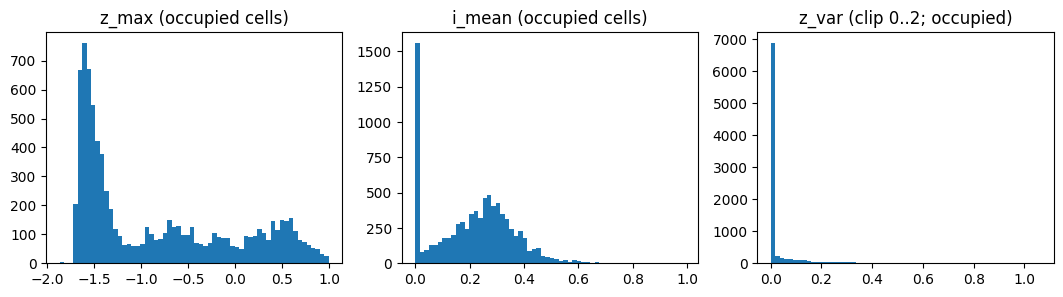

Occupied cells: 8416 / 563200 (1.49%)


In [38]:
# Cell F2 — histograms on OCCUPIED cells only (count>0)
import numpy as np, matplotlib.pyplot as plt

occ = bev_f[0] > 0
zmax_occ  = bev_f[1][occ]
imean_occ = bev_f[3][occ]
zvar_occ  = bev_f[4][occ]

fig,axs = plt.subplots(1,3,figsize=(13,3))
axs[0].hist(zmax_occ,  bins=60); axs[0].set_title("z_max (occupied cells)")
axs[1].hist(imean_occ, bins=60); axs[1].set_title("i_mean (occupied cells)")
axs[2].hist(np.clip(zvar_occ,0,2), bins=60); axs[2].set_title("z_var (clip 0..2; occupied)")
plt.show()

print("Occupied cells:", occ.sum(), "/", occ.size, f"({100*occ.mean():.2f}%)")


In [40]:
# Cell F3 — suggest caps from first N frames (occupied cells)
from pathlib import Path
import numpy as np
N = 19  # adjust
ids = sorted(p.stem for p in VELO.glob("*.bin"))[:N]

counts = []; zvars = []
for fid in ids:
    raw = np.fromfile(VELO / f"{fid}.bin", dtype=np.float32).reshape(-1,4)
    bf = bev_from_points(raw, cfg)
    occ = bf[0] > 0
    counts.append(bf[0][occ])
    zvars.append(bf[4][occ])

counts = np.concatenate(counts) if counts else np.array([0.0])
zvars  = np.concatenate(zvars)  if zvars  else np.array([0.0])

p95_count = float(np.percentile(counts, 95)) if counts.size else 5.0
p99_zvar  = float(np.percentile(zvars, 99))  if zvars.size  else 1.0

print(f"Suggested count_cap ≈ p95 = {p95_count:.2f} (current {cfg['q']['count_cap']})")
print(f"Suggested zvar_cap  ≈ p99 = {p99_zvar:.2f} (current {cfg['q']['zvar_cap']})")


Suggested count_cap ≈ p95 = 8.00 (current 5.0)
Suggested zvar_cap  ≈ p99 = 0.57 (current 0.2)


In [41]:
# Cell G — batch N frames to files (float + u8)
from tqdm import tqdm
from pathlib import Path

N = 50  # change as you like
ids = sorted(p.stem for p in VELO.glob("*.bin"))[:N]
outF = Path(PROJECT_DIR) / "outputs" / "bev_float"
outU = Path(PROJECT_DIR) / "outputs" / "bev_u8"
outF.mkdir(parents=True, exist_ok=True); outU.mkdir(parents=True, exist_ok=True)

for fid in tqdm(ids):
    raw = np.fromfile(VELO / f"{fid}.bin", dtype=np.float32).reshape(-1, 4)
    bev_f = bev_from_points(raw, cfg)
    bev_u = quantize_bev_u8(bev_f, cfg)
    np.save(outF / f"{fid}.npy", bev_f)
    np.save(outU / f"{fid}.npy", bev_u)

print("Saved", len(ids), "frames to:", outF, "and", outU)


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.21it/s]

Saved 50 frames to: C:\Users\DELL\projects\bev_npu\outputs\bev_float and C:\Users\DELL\projects\bev_npu\outputs\bev_u8


In [42]:
# Cell H — tiling (64×64) with 1-px halo, stitch back, zero-tile stats
import numpy as np
from pathlib import Path

def tile_with_halo(arr_chw: np.ndarray, tile=64, halo=1):
    C,H,W = arr_chw.shape
    tiles, meta = [], []
    for y0 in range(0, H, tile):
        for x0 in range(0, W, tile):
            y1 = min(y0 + tile, H); x1 = min(x0 + tile, W)
            yh0 = max(0, y0 - halo); xh0 = max(0, x0 - halo)
            yh1 = min(H, y1 + halo); xh1 = min(W, x1 + halo)
            tiles.append(arr_chw[:, yh0:yh1, xh0:xh1].copy())
            meta.append((x0,y0,x1,y1, xh0,yh0,xh1,yh1))
    return tiles, meta

def stitch_from_tiles(pred_tiles, meta, H, W, tile=64):
    out = np.zeros((pred_tiles[0].shape[0], H, W), dtype=pred_tiles[0].dtype)
    for t,(x0,y0,x1,y1,xh0,yh0,xh1,yh1) in zip(pred_tiles, meta):
        dy0 = y0 - yh0; dy1 = dy0 + (y1 - y0)
        dx0 = x0 - xh0; dx1 = dx0 + (x1 - x0)
        out[:, y0:y1, x0:x1] = t[:, dy0:dy1, dx0:dx1]
    return out

def is_zero_tile(tile: np.ndarray) -> bool:
    return tile.sum() == 0

fid = frame_id  # reuse from Cell E (or set explicitly)
sample = np.load(Path(PROJECT_DIR) / "outputs" / "bev_u8" / f"{fid}.npy")  # [5,H,W]
tiles, meta = tile_with_halo(sample, tile=64, halo=1)
print(f"Tiles: {len(tiles)}; first tile shape:", tiles[0].shape)

stitched = stitch_from_tiles(tiles, meta, sample.shape[1], sample.shape[2], tile=64)
assert np.array_equal(stitched, sample), "Stitch mismatch — check halo logic"
print("Stitch OK.")

skip = sum(is_zero_tile(t) for t in tiles)
print(f"Zero tiles: {skip}/{len(tiles)}  (~{100*skip/len(tiles):.1f}% skipped)")


Tiles: 143; first tile shape: (5, 65, 65)
Stitch OK.
Zero tiles: 0/143  (~0.0% skipped)


In [43]:
# Cell I — save tiles + meta (for PS→PL streaming tests)
from pathlib import Path
import json
import numpy as np

fid = frame_id  # or set any saved id
bev_u = np.load(Path(PROJECT_DIR) / "outputs" / "bev_u8" / f"{fid}.npy")
tiles, meta = tile_with_halo(bev_u, tile=64, halo=1)

tile_dir = Path(PROJECT_DIR) / "outputs" / "tiles"
tile_dir.mkdir(parents=True, exist_ok=True)

for idx, t in enumerate(tiles):
    np.save(tile_dir / f"{fid}_t{idx:03d}.npy", t)

meta_json = {
    "H": int(bev_u.shape[1]),
    "W": int(bev_u.shape[2]),
    "tile": 64,
    "halo": 1,
    "channels": cfg["channels"],
    "meta": [list(m) for m in meta]  # (x0,y0,x1,y1, xh0,yh0,xh1,yh1)
}
(tile_dir / f"{fid}_meta.json").write_text(json.dumps(meta_json, indent=2))
print("Wrote tiles + meta to:", tile_dir)


Wrote tiles + meta to: C:\Users\DELL\projects\bev_npu\outputs\tiles


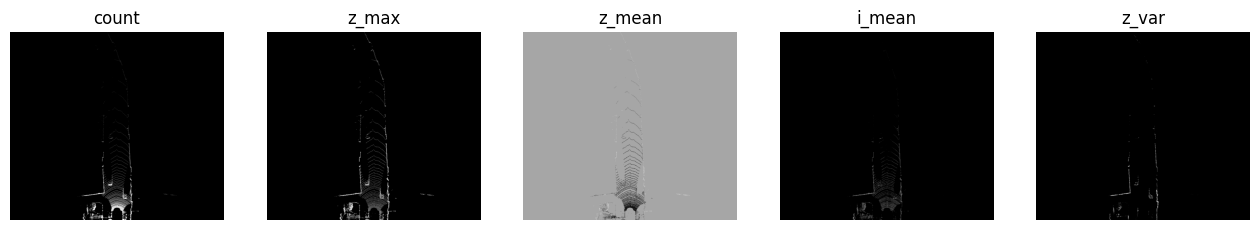

In [44]:
# Cell J — per-channel BEV images (uint8)
import matplotlib.pyplot as plt
ch_names = cfg["channels"]
fig,axs = plt.subplots(1,5,figsize=(16,3))
for c in range(5):
    axs[c].imshow(bev_u[c], cmap='gray', origin='lower')
    axs[c].set_title(ch_names[c]); axs[c].axis('off')
plt.show()
